# Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## Importing Libraries

In [1]:
from PIL import Image

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import zscore

#regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

#model preprocessing
from sklearn.preprocessing import OneHotEncoder

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.model_selection import cross_val_score #for optuna

#optuna
import optuna
import joblib

## Loading data

In [3]:
data = pd.read_csv("bike-sharing_hourly.csv")

In [4]:
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


## PART I: Exploratory Data Analysis

### Data quality

#### Null values

There are not any null values in the dataset.

In [5]:
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### Duplicates

There are not any duplicates in the dataset.

In [6]:
data.duplicated().any()

False

#### Data types

We excluded the year column due to its limited information content. The remaining features have been verified to possess appropriate data types and are prepared for further analysis.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


#### Outliers

We used z-score calculation to identify outliers in temperature-related features, such as temperature, felt temperature, humidity, and windspeed, discarding values with z-scores greater than 3 to ensure data accuracy and reliability for subsequent analyses and modeling. This quality assurance step enhances the robustness of our findings and predictive models by mitigating the impact of extreme anomalies.

In [8]:
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [9]:
# columns is the list of column names for which Z-Score needs to be computed
columns = ['temp', 'atemp', 'hum', 'windspeed']

# Compute Z-Score
z_scores = zscore(data[columns])

# Create a boolean index indicating if it's an outlier
outliers = (z_scores > 3).any(axis=1)

# Remove rows with outliers
cleaned_df = data[~outliers]

# Output the DataFrame after removing outliers
print(cleaned_df)

       instant      dteday  season  yr  mnth  hr  holiday  weekday  \
0            1  2011-01-01       1   0     1   0        0        6   
1            2  2011-01-01       1   0     1   1        0        6   
2            3  2011-01-01       1   0     1   2        0        6   
3            4  2011-01-01       1   0     1   3        0        6   
4            5  2011-01-01       1   0     1   4        0        6   
...        ...         ...     ...  ..   ...  ..      ...      ...   
17374    17375  2012-12-31       1   1    12  19        0        1   
17375    17376  2012-12-31       1   1    12  20        0        1   
17376    17377  2012-12-31       1   1    12  21        0        1   
17377    17378  2012-12-31       1   1    12  22        0        1   
17378    17379  2012-12-31       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
0               0           1  0.24  0.2879  0.81     0.0000       3   
1              

### Univariate Analysis

In the presented visualization, we opted to focus solely on the distribution analysis of key variables, namely workingday, temperature, felt temperature, humidity, and wind speed. This decision was informed by the observed correlation among date-related features, which led us to prioritize these specific factors for our analysis.

We observe that the dataset exhibits centered values, with occurrences of extreme weather being infrequent. This suggests a smaller dataset available for predicting outcomes under such extreme weather conditions. Consequently, it's likely that the model's performance may degrade when confronted with inputs corresponding to extreme weather conditions.

In [10]:
X = cleaned_df.drop(columns=['instant','dteday','casual','registered','cnt','yr'])
y = cleaned_df.cnt
y = y.reset_index(drop=True)


In [11]:
plot_data = X[['workingday','temp','atemp','hum','windspeed']]

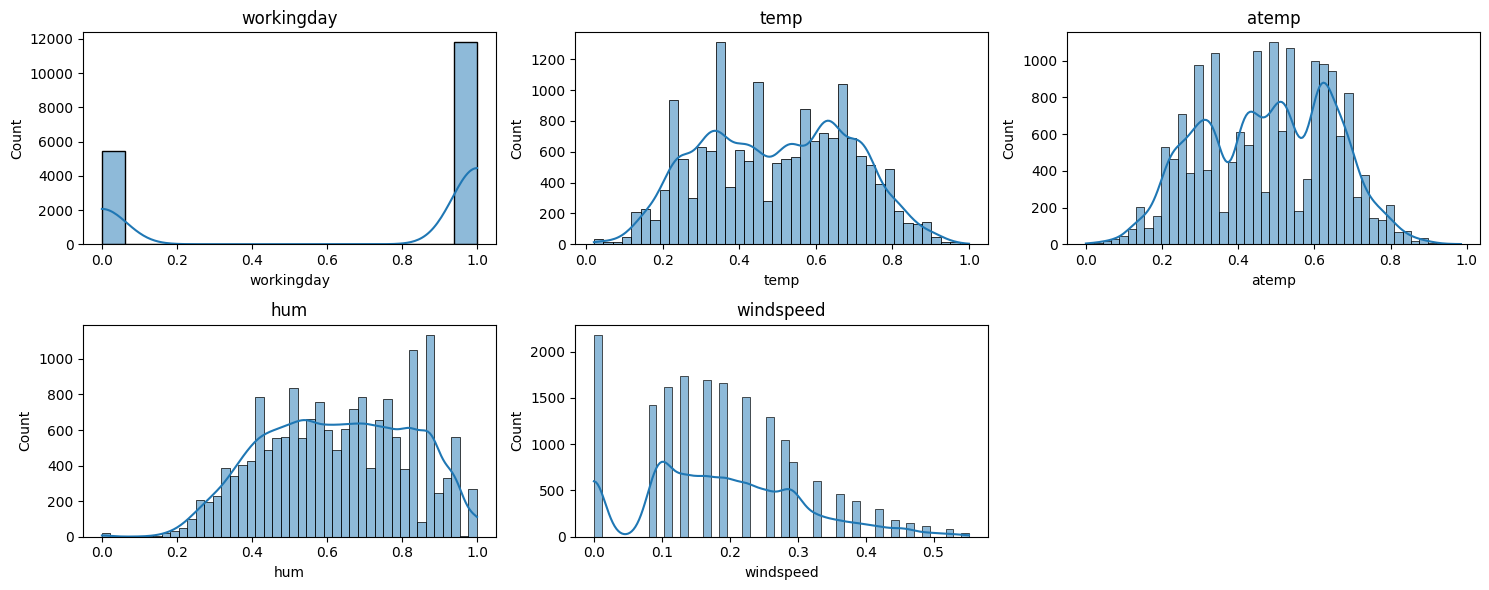

In [12]:
num_rows = (len(plot_data.columns) + 2) // 3
num_cols = 3

# Create the figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Set background color for the figure
#fig.patch.set_facecolor('#EAE0D5')

# Iterate over columns and plot histograms
for i, column in enumerate(plot_data.columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(plot_data[column], kde=True, ax=axes[row, col])
    axes[row, col].set_title(column)
    
    # Set background color for each axis
    #axes[row, col].set_facecolor('#EAE0D5')

# Remove any excess axes
for i in range(len(plot_data.columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout and display plot
plt.tight_layout()
plt.show()

### Bivariate Analysis

Here, we analyze the bike rental counts from two distinct perspectives: seasonal variations and hourly patterns.

In this chart, we depicted the bike rental counts categorized by hours and seasons, revealing a significant disparity among the seasons. Notably, autumn (season 3) exhibits the highest rental counts, while spring (season 1) registers the lowest.

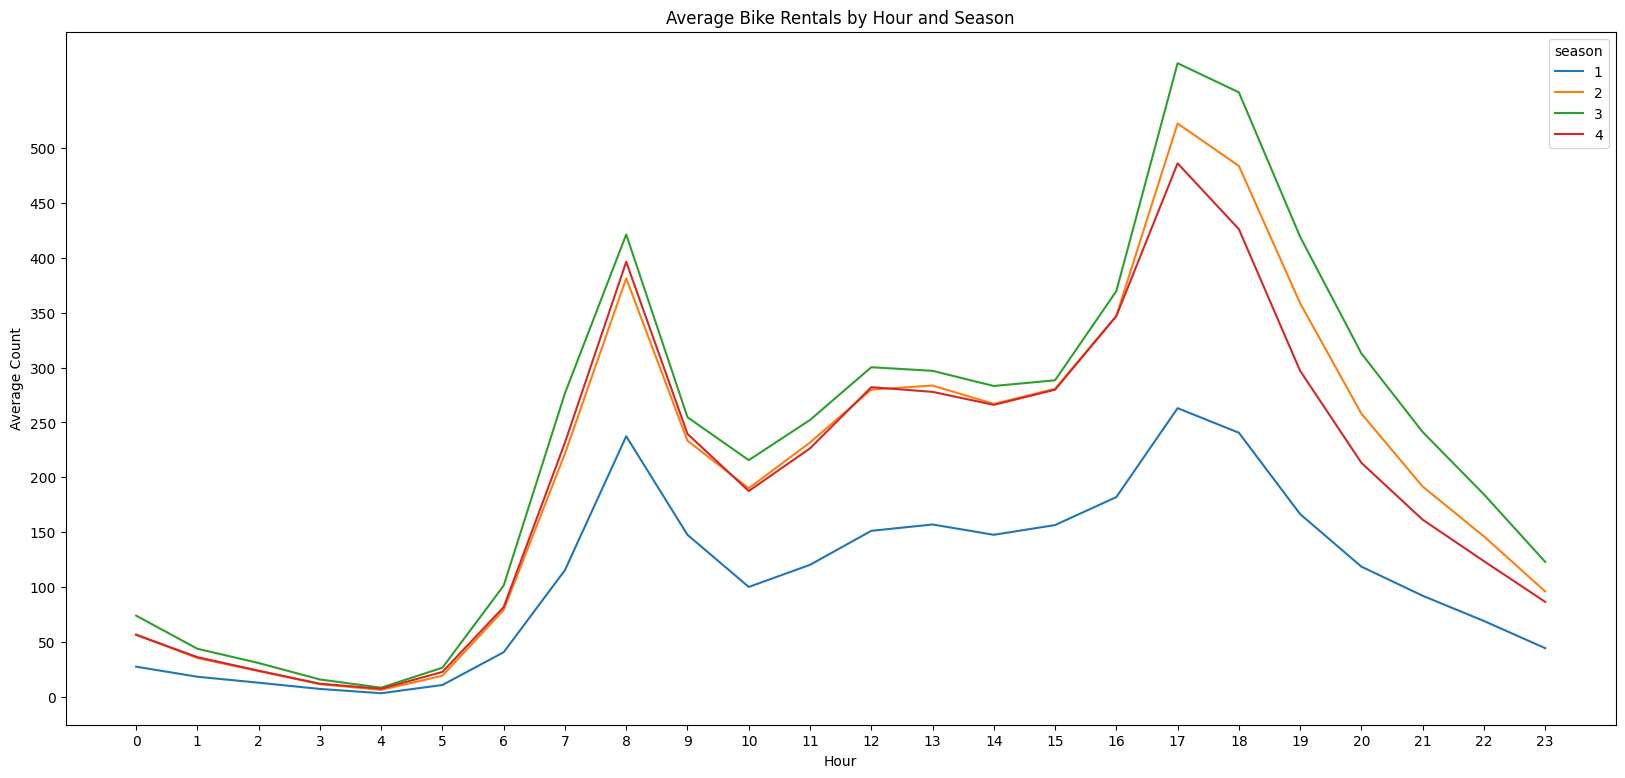

In [13]:
fig, ax = plt.subplots(figsize=(20, 9))
cleaned_df[cleaned_df.cnt.notnull()].groupby(["hr", "season"]).cnt.mean().unstack().plot(ax=ax, xticks=range(0, 24), yticks=range(0, 550, 50))

# Set the background color
#fig.patch.set_facecolor('#EAE0D5')
#ax.set_facecolor('#EAE0D5')

# Adjust other plot settings
plt.title('Average Bike Rentals by Hour and Season')
plt.xlabel('Hour')
plt.ylabel('Average Count')
ax.grid(False)

plt.show()

In this visualization, it's evident that on working days, there's a notable increase in bike rentals during rush hours, specifically between 7 to 9 in the morning and 17 to 19 in the evening. Conversely, on non-working days, the trend appears smoother, with bike rentals peaking between 10 to 20, indicating a more evenly distributed usage pattern throughout the day.

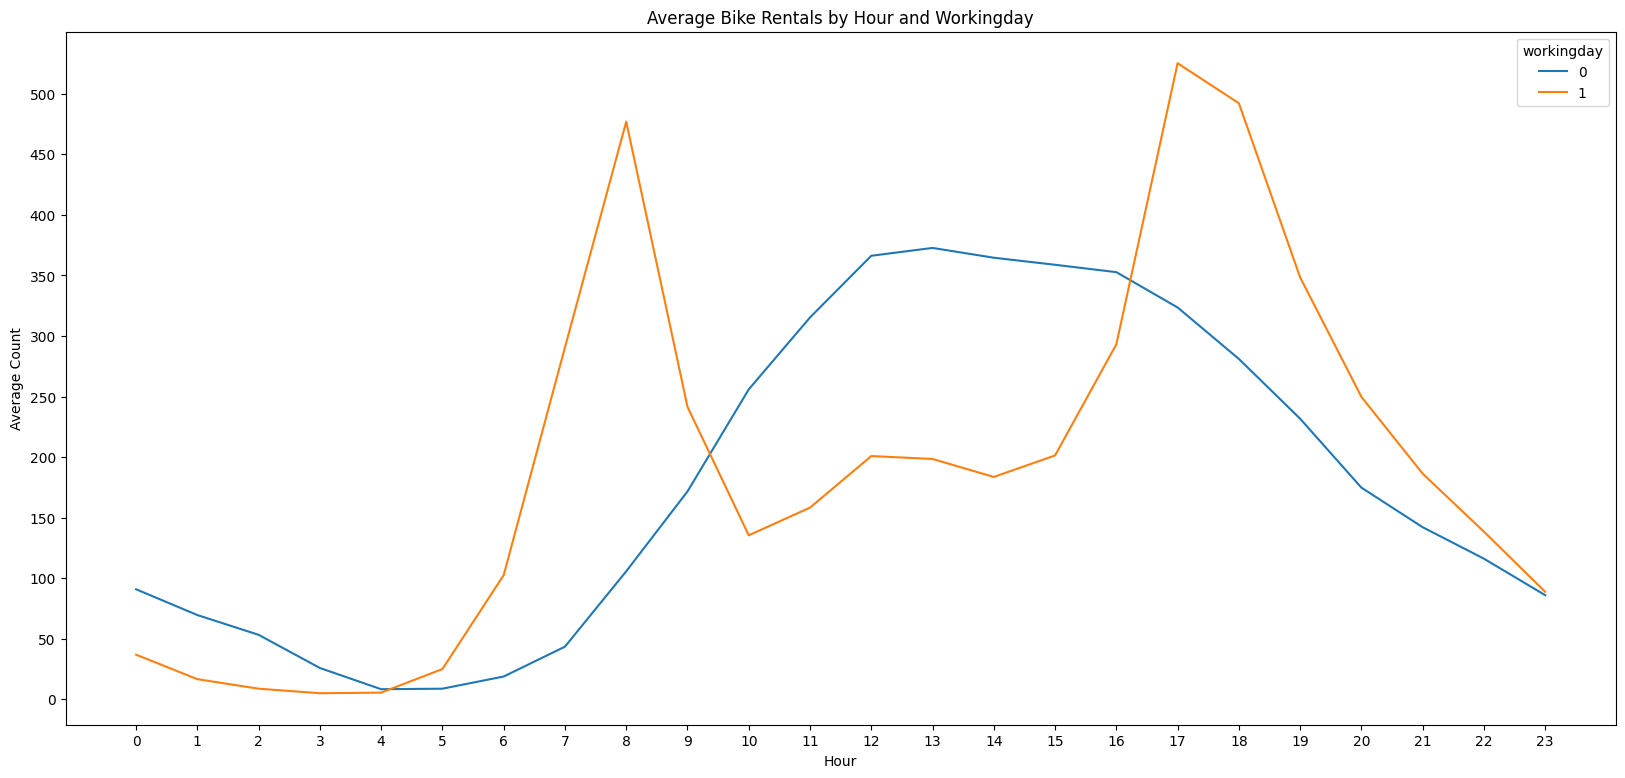

In [14]:
fig, ax = plt.subplots(figsize=(20, 9))
data[data.cnt.notnull()].groupby(["hr", "workingday"]).cnt.mean().unstack().plot(ax=ax, xticks=range(0, 24), yticks=range(0, 550, 50))

# Set the background color
#fig.patch.set_facecolor('#EAE0D5')
#ax.set_facecolor('#EAE0D5')

# Adjust other plot settings
plt.title('Average Bike Rentals by Hour and Workingday')
plt.xlabel('Hour')
plt.ylabel('Average Count')
ax.grid(False)

plt.show()

In the correlation matrix shown below, it indicates that humidity exhibits a strong negative correlation with the bike rental counts.

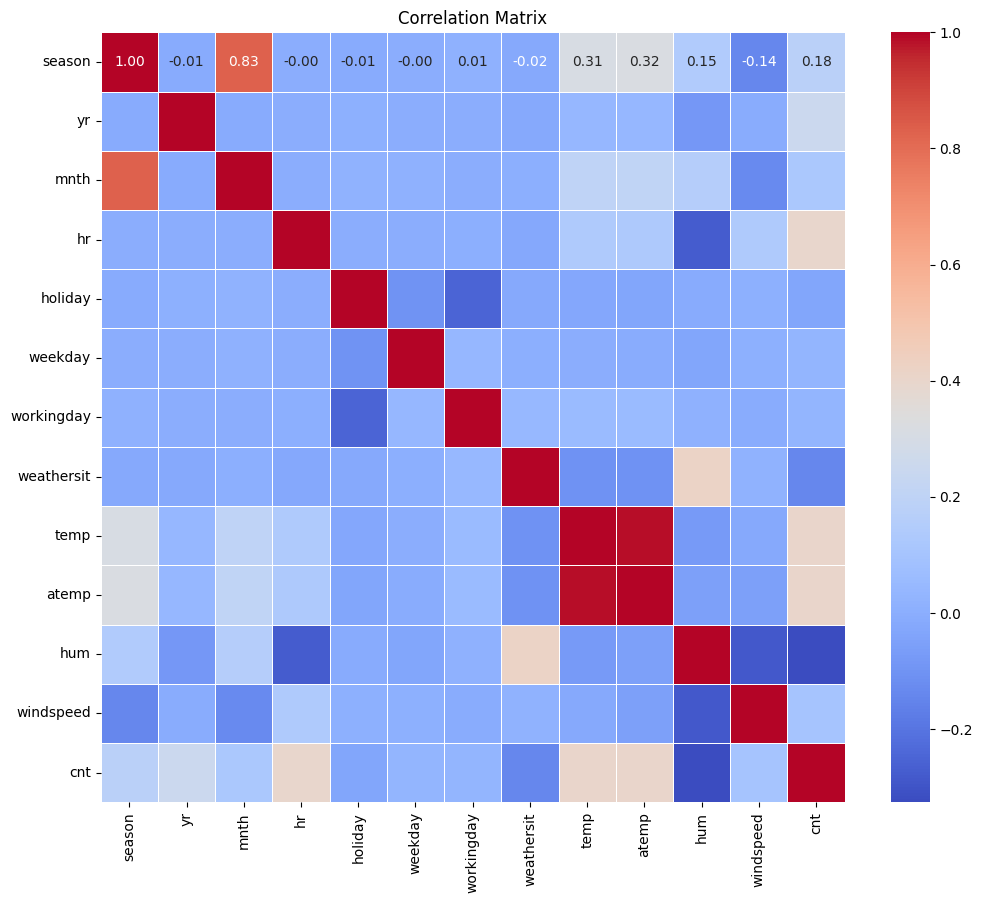

In [16]:
correlation_matrix = cleaned_df.drop(columns=['instant','dteday','casual','registered']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## PART II: Prediction Model

### Feature Engineering

#### Rush_hour

We've introduced a new variable, rush_hr, specifically tailored for working days, encompassing the timeframes from 7 to 9 in the morning and from 17 to 19 in the evening, as there is a strong relation between the hours and the bike rental counts.

In [17]:
X['rush_hr'] = 0
X.loc[((X['hr'].between(7, 9) | X['hr'].between(17, 19)) & (X['workingday'] == 1)), 'rush_hr'] = 1

In [18]:
X.reset_index(inplace=True)

#### One-hot encoding

We conducted one-hot encoding for the variables season and weathersit.

In [19]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_columns = ['season', 'weathersit']
categorical_columns_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
X = pd.concat([X.drop(categorical_columns, axis=1), categorical_columns_encoded], axis=1)
X.drop(columns='index',inplace= True)

### Model development

We first ran a model with the default hyperparameters to see which model performs better. According to the results shown below, random forest and xgboost have similar performances, so we decided to use random forest for the model.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define a list of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Machine': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}

# Evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Display results
    print(f"Model: {model_name}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    print("----------------------------")

Model: Linear Regression
Mean Absolute Error (MAE): 84.72
Root Mean Squared Error (RMSE): 113.63
R-squared (R2): 0.60
----------------------------
Model: Decision Tree
Mean Absolute Error (MAE): 53.28
Root Mean Squared Error (RMSE): 87.38
R-squared (R2): 0.76
----------------------------
Model: Random Forest
Mean Absolute Error (MAE): 41.06
Root Mean Squared Error (RMSE): 62.86
R-squared (R2): 0.88
----------------------------
Model: Support Vector Machine
Mean Absolute Error (MAE): 91.39
Root Mean Squared Error (RMSE): 142.16
R-squared (R2): 0.37
----------------------------
Model: XGBoost
Mean Absolute Error (MAE): 40.81
Root Mean Squared Error (RMSE): 60.99
R-squared (R2): 0.88
----------------------------


XGBoost and Random Forest seem to be the models with lowest mean absolute error. For model development, we used optuna to conduct the hyperparameter tuning to select the best model. The following is the result of the model.

In [21]:
def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_float('max_features', 0.01, 1.0)

    # Create RandomForestRegressor with suggested hyperparameters
    rf_reg = RandomForestRegressor	(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Use cross-validation to evaluate the model

    score = -cross_val_score(rf_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    
    # Return the average MAE 
    return score

In [22]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=200)

[I 2024-03-17 07:43:57,532] A new study created in memory with name: no-name-2db81698-b1be-49d1-91c2-3c116bc21e29
[I 2024-03-17 07:43:59,165] Trial 0 finished with value: 74.00629837329426 and parameters: {'n_estimators': 218, 'max_depth': 42, 'min_samples_split': 37, 'min_samples_leaf': 30, 'max_features': 0.16445845403801215}. Best is trial 0 with value: 74.00629837329426.
[I 2024-03-17 07:43:59,947] Trial 1 finished with value: 90.918745085429 and parameters: {'n_estimators': 120, 'max_depth': 2, 'min_samples_split': 44, 'min_samples_leaf': 31, 'max_features': 0.710991852018085}. Best is trial 0 with value: 74.00629837329426.
[I 2024-03-17 07:44:00,654] Trial 2 finished with value: 60.23799293758867 and parameters: {'n_estimators': 59, 'max_depth': 45, 'min_samples_split': 42, 'min_samples_leaf': 11, 'max_features': 0.19000671753502962}. Best is trial 2 with value: 60.23799293758867.
[I 2024-03-17 07:44:01,019] Trial 3 finished with value: 77.77430233929066 and parameters: {'n_estim

Here's the best hyperparameters found.

In [23]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 200, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.7309068686415673}


In [24]:
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
best_max_features = best_params['max_features']

In [25]:
best_model = RandomForestRegressor(n_estimators=best_n_estimators,
                                    max_depth=best_max_depth,
                                    min_samples_split=best_min_samples_split,
                                    min_samples_leaf=best_min_samples_leaf,
                                    max_features=best_max_features,
                                    random_state=42)

In [26]:
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=23, max_features=0.7309068686415673,
                      min_samples_leaf=4, min_samples_split=7, n_estimators=200,
                      random_state=42)

We use the model to predict the test set, to see the performance.

In [27]:
y_pred = best_model.predict(X_test)

In [28]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Display results
print(f"Model: Random Forest")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R2): {r2:.2f}")
print("----------------------------")

Model: Random Forest
Mean Absolute Error (MAE): 42.74
Root Mean Squared Error (RMSE): 64.83
Mean Absolute Percentage Error (MAPE): 41.37%
R-squared (R2): 0.87
----------------------------


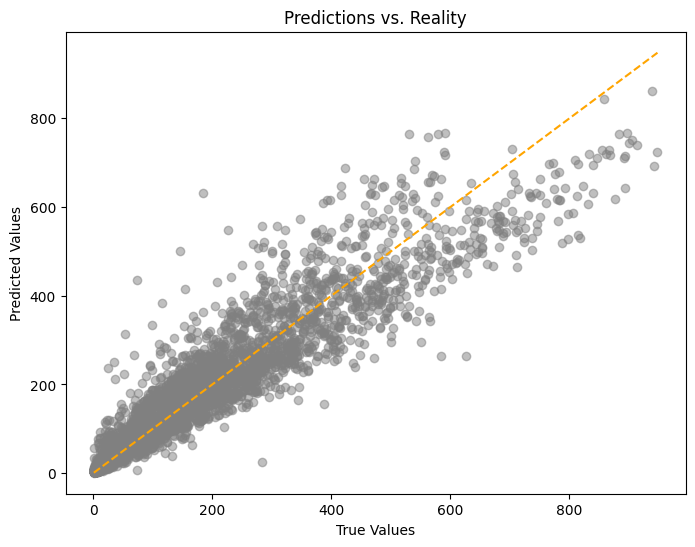

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
# Scatter plot
ax.scatter(y_test, y_pred, color='grey', alpha=0.5)
# Plot the diagonal line
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='orange')
# Set the title and labels
ax.set_title('Predictions vs. Reality')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
# Set the background color for the figure and the axis
#fig.patch.set_facecolor('#EAE0D5')
#ax.set_facecolor('#EAE0D5')
plt.show()

#### Exporting the model

## PART III: Streamlit dashboard

In [30]:
### This part goes in a separate script ###